In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [16]:
# vairables initialization
BATCH_SIZE = 100
LR = 1e-3
EPOCHS = 30

In [17]:
# data loading

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root = './data', train=True, transform=transform , download=True)
test_dataset = datasets.MNIST(root = './data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Data loading done\nTrain data size = {len(train_dataset)}\nTest data size = {len(test_dataset)}")
print(f"Shape of data = {train_dataset[0][0].shape}") # the dataset is (image_vecetor, label)


Data loading done
Train data size = 60000
Test data size = 10000
Shape of data = torch.Size([1, 28, 28])


In [18]:
# Model architecture

class VAE(nn.Module) :
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20) :
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # log(variance)
        
        # decoder part
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x) :
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar) :
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z) :
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x) :
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        

In [19]:
# initialization and training

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=LR)

def loss_function(recon_x, x, mu, logvar) :
    # BCE used instead of MSE as MNIST is nearly all B&W pictures
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') 
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return BCE + KLD

print("Model initialized")

Model initialized


In [20]:
# starting training

model.train()

train_losses = []
print("Training started -")

for epoch in range(EPOCHS) :
    overall_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_loader) :
        optimizer.zero_grad()
        recon_x, mu, logvar = model.forward(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
    
    average_loss = overall_loss / len(train_loader.dataset)
    train_losses.append(average_loss)
    
    print(f"epoch = {epoch + 1} \t Average Loss = {average_loss}")
    

Training started -
epoch = 1 	 Average Loss = 157.75671162109376
epoch = 2 	 Average Loss = 119.36630209960937
epoch = 3 	 Average Loss = 113.3469583984375
epoch = 4 	 Average Loss = 110.72612620442709
epoch = 5 	 Average Loss = 109.11987765299479
epoch = 6 	 Average Loss = 108.07445122070312
epoch = 7 	 Average Loss = 107.28555678710937
epoch = 8 	 Average Loss = 106.67134620768229
epoch = 9 	 Average Loss = 106.21011959635416
epoch = 10 	 Average Loss = 105.81882721354167
epoch = 11 	 Average Loss = 105.4931341796875
epoch = 12 	 Average Loss = 105.2082580078125
epoch = 13 	 Average Loss = 104.96714459635416
epoch = 14 	 Average Loss = 104.71298460286458
epoch = 15 	 Average Loss = 104.49285073242187
epoch = 16 	 Average Loss = 104.41288344726563
epoch = 17 	 Average Loss = 104.2085571126302
epoch = 18 	 Average Loss = 104.03885751953125
epoch = 19 	 Average Loss = 103.89970538736979
epoch = 20 	 Average Loss = 103.7627568359375
epoch = 21 	 Average Loss = 103.61826770833333
epoch = 

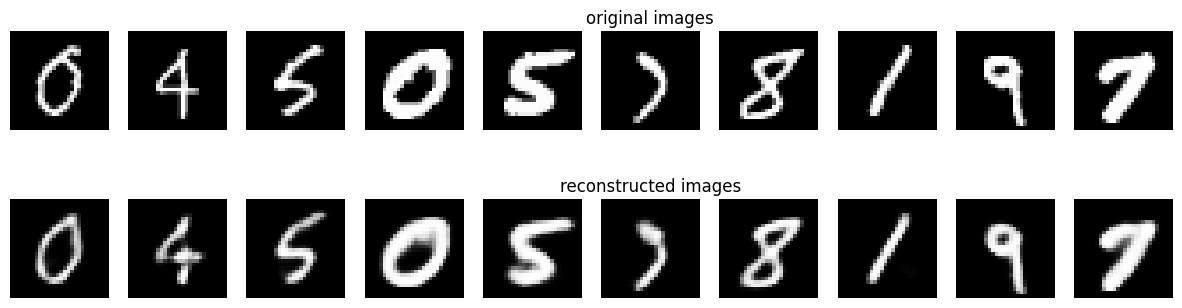

In [31]:
# evaluation of the model now
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad() :
    data, _ = next(iter(test_loader))
    recon_batch, mu, logvar = model.forward(data)

fig, axes = plt.subplots(2, 10, figsize=(15, 4)) 

for i in range(10) :
    axes[0, i].imshow(data[i].view(28, 28), cmap="gray")
    axes[0, i].axis("off")
    if i == 5: axes[0, i].set_title("original images")
    axes[1, i].imshow(recon_batch[i].view(28, 28), cmap="gray")
    axes[1, i].axis("off")
    if i == 5: axes[1, i].set_title("reconstructed images")

plt.show()

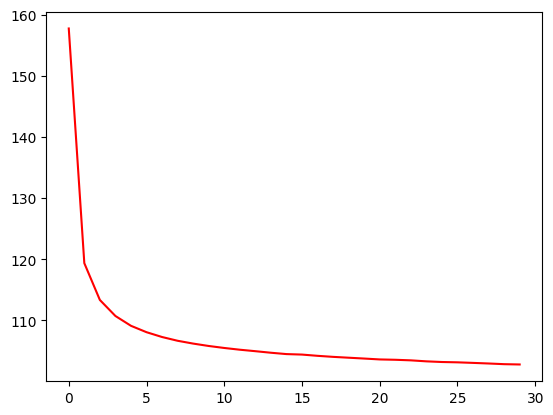

In [35]:
idx_loss = []
idx = []
for i in range(len(train_losses)):
    idx.append(i)
    
idx_loss.append(idx)
idx_loss.append(train_losses)

plt.plot(idx_loss[0], idx_loss[1], color="red")
plt.show()

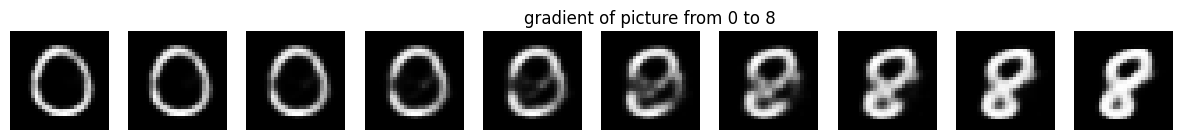

In [40]:
first_found = False
second_found = False

FIRST_NUMBER = 8
SECOND_NUMBER = 0

with torch.no_grad() :
    data, label = next(iter(test_loader))
    recon_batch, mu, logvar = model.forward(data)

first_data = None
second_data = None

i = 0
while(not (first_found and second_found)):
    if label[i] == FIRST_NUMBER :
        first_data = data[i]
        first_found = True
    
    if label[i] == SECOND_NUMBER :
        second_data = data[i]
        second_found = True
    
    i += 1

first_mu, first_logvar = model.encode(first_data.reshape(1, 784))
second_mu, second_logvar = model.encode(second_data.reshape(1, 784))

gradient = []

for i in range(10) :
    gradient.append(model.decode(first_mu*(i/10) + second_mu*(1 - i/10)))

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10) :
    axes[i].imshow((gradient[i].detach().numpy()).reshape(28, 28), cmap="gray")
    axes[i].axis("off")
    if i == 5: axes[i].set_title(f"gradient of picture from {SECOND_NUMBER} to {FIRST_NUMBER}")